# Controlling the MLSVD truncation 

One of the most important things one need to get right is the truncation of the MLSVD. It doesn't matter how optimized are the CPD routines, it will take a long time to finish the computations if the tensor is big and no compression is made. Many other CPD solvers out there skip the compression stage, and this is one of the reasons (but not the only one) why Tensor Fox is faster. In this lesson we will see some tricks to obtain a decent preprocessed tensor in which we will compute its CPD. Let's work again with the swimmer tensor.

In [1]:
import numpy as np
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import TensorFox as tfx

In [2]:
# Load the tensor T. 
T = np.load('swimmer.npy')
dims = T.shape
L = len(T.shape)
Tsize = np.linalg.norm(T)

Again, we will consider the rank as $R = 50$. As mentioned in lesson 3, the reduced MLSVD of $T$ is given by $T = (U_1, U_2, U_3) \cdot S$, where $S \in \mathbb{R}^{R_1 \times R_2 \times R_3}$, $U_1 \in \mathbb{R}^{256 \times R_1}$, $U_2 \in \mathbb{R}^{32 \times R_2}$, $U_3 \in \mathbb{R}^{32 \times R_3}$. The tuple $(R_1, R_2, R_3)$ is the multilinear rank of $T$. When the **cpd** function is called, its first action is to run a MLSVD routine and estimate the values $R_1, R_2, R_3$. Since these values are obtained by approximation, the resulting core tensor $S$ is actually a truncation. Below we run the **cpd** with $T$ to remember this.

In [3]:
# Compute the CPD of T, assuming T has rank 50. 
class options:
    display = 3
    
R = 50
factors, output = tfx.cpd(T, R, options)

-> With display > 2 Tensor Fox will compute the error of the MLSVD. For large tensors this routine is very clostly.


-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compressing unfolding mode 1
    Compressing unfolding mode 2
    Compressing unfolding mode 3
    Compression detected
    Compressing from (256, 32, 32) to (13, 23, 15)
    Compression relative error = 1.459281e-10
-----------------------------------------------------------------------------------------------
Type of initialization: random
    Initial guess relative error = 1.341551e+00
-----------------------------------------------------------------------------------------------
Computing CPD
    Iteration | Rel error |  Step size  | Improvement | norm(grad) | Predicted error | # Inner iterations
        1     | 1.25e+00  |  4.73e-02   |  1.25e+00   |  2.17e+03  |    5.07e-03     |        2        
        2     | 1.21e+00  |  1.97e-02   |  3.45e-02   |  1.66e+03  |    1.01e-04     |        3        
        3     | 1.12e+00  |  5.68e-02   |  8.98e-02   |  1.51e+03  |

       81     | 1.95e-03  |  6.03e-03   |  4.47e-05   |  5.18e-01  |    5.21e-08     |        27       
       82     | 1.89e-03  |  2.35e-03   |  5.63e-05   |  7.20e-01  |    6.81e-09     |        46       
       83     | 1.88e-03  |  1.21e-03   |  1.56e-05   |  3.13e-01  |    3.39e-09     |        24       
       84     | 1.83e-03  |  6.97e-03   |  4.59e-05   |  1.74e-01  |    4.34e-08     |        39       
       85     | 1.78e-03  |  1.86e-02   |  5.69e-05   |  4.49e-01  |    7.49e-08     |        55       
       86     | 1.56e-03  |  2.35e-03   |  2.19e-04   |  1.22e+00  |    2.78e-09     |        30       
       87     | 1.54e-03  |  2.57e-03   |  2.19e-05   |  1.21e-01  |    5.14e-09     |        39       
       88     | 1.51e-03  |  2.13e-03   |  2.26e-05   |  1.62e-01  |    4.88e-09     |        39       
       89     | 1.50e-03  |  1.46e-03   |  1.57e-05   |  2.07e-01  |    3.23e-09     |        39       
       90     | 1.49e-03  |  7.99e-04   |  7.73e-06   |  3.47e-0

What we know for sure is that $R_1 \leq \min\{ R, m \}$, $R_2 \leq \min\{ R, n \}$, $R_3 \leq \min\{ R, p \}$, where $m, n, p$ are the dimensions of $T$. This is valid in general for order-$L$ tensors, i.e., $R_\ell \leq \min\{ R, I_\ell \}$ for all $\ell = 1 \ldots L$. For example, in the case of the swimmer tensor this tuple is $(50, 32, 32)$, but we just saw that the tuple $(13, 23, 15)$ is already very good (with error of order $10^{-10}$). 

# Truncation testing 

In more difficult situations one may be interested in testing a list of several possible truncations and choose one of them. This can be accomplished with the function **test_truncation**. Below we will show an example with the swimmer tensor. 

**PS:** The ordering of the dimensions are different here. The **cpd** function sorts the dimension of $T$ in descending order, so the original tensor with shape $32 \times 32 \times 256$ is rearranged to have shape $256 \times 32 \times 32$. The truncation testing doesn't change the dimension ordering, so the optimal truncation $(13, 23, 15)$ mentioned before is for the sorted $T$. In this context the optimal truncation now is $(23, 15, 13)$. 

Recommended truncation = (23, 15, 13)     Relative error = 1.0097645776857521e-15 



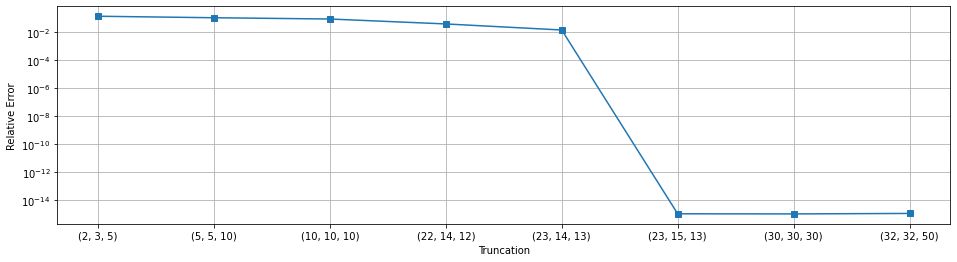

In [4]:
# List a few truncations (a, b, c) wherea a <= 32, b <= 32 and c <= 50. 
trunc_list = [(2, 3, 5), (5, 5, 10), (10, 10, 10), (22, 14, 12), (23, 14, 13), (23, 15, 13), (30, 30, 30), (32, 32, 50)]

# Start the tests.
trunc_error = tfx.test_truncation(T, trunc_list, display=False)

# Now we plot the evolution of the energy and the corresponding errors.
df = pd.DataFrame(index= [str(x) for x in trunc_list], data=trunc_error, columns=['Error'])

# Print the first truncation with error than 1e-13.
for idx in df.index:
    if df.loc[idx, 'Error'] < 1e-13:
        print('Recommended truncation =', idx, '    Relative error =', df.loc[idx, 'Error'], '\n')
        break

df.plot(figsize=[16, 4], grid=True, legend=[], marker='s')
plt.ylabel('Relative Error')
plt.xlabel('Truncation')
plt.yscale('log')
plt.show()

# Why do we need to do this if Tensor Fox is better?

Actually, the original purpose function **test_truncation** wasn't to find the optimal truncation, but to understand how the error changes as the truncation changes. In general the error behaves as the example above, i.e., it doesn't change gradually but abruptly. 

Also it is important to remark that Tensor Fox works with approximations (like any solver), therefore the truncation given by Tensor Fox may not be always the optimal one. In that case it would be interesting for the user to use this truncation as starting point to test closer truncations. Sometimes they can find a smaller truncation with the same relative error. That wasn't the case for this particular example because Tensor Fox did found the optimal truncation.

# Using the compressed tensor instead of the original one

Just a quick recap: 
 - We have our original raw tensor $T$, which is big and probably can be compressed.
 - $T = (U_1, \ldots, U_L) \cdot S$, where $S$ is the *core* tensor of the MLSVD of $T$. It is the compressed version of $T$.
 - All the talk above about truncation was about $S$, not $T$, you probably understand this at this point.
 - The dimensions of $S$ are $(R_1, \ldots, R_L)$ and they satisfy $R_\ell \leq \min\{I_\ell, R\}$, where $I_\ell$ is the $\ell$-th dimension of $T$ and $R$ is the rank of $T$.
 - The CPD will be computed for $S$, because its cheaper to compute this CPD and once we have this CPD, the CPD of $T$ is easily obtained. 
 - When we call the function **cpd** with Tensor Fox, it computes the compression $S$ and then the CPD of $S$. 
 
Assume that the compression computed is precise enough. Still we can have bad luck when computing the CPD, that is, the program may converge to a local minimum. The solution won't be close enough and we will have to run the **cpd** all over again. Maybe the second time it is better (and probably will be if the problem is not ill-posed). Regardless, we are computing the compression twice, once per **cpd** call. If the tensor is very large, we don't want to repeat this step several times.

**The solution is**: We compute compression by ourselves and store it, then we can compute its CPD several times.

In [5]:
# Start creating the class of options.
class options:    
    # Define the error tolerance but do not use a value <= 0 to compute the compression directly like we are doing now.
    tol_mlsvd = 1e-16    
    
# Call the MLSVD function. Only S and U matters for us.
S, U, T1, sigmas = tfx.mlsvd(T, Tsize, R, options)    

In [6]:
# Now we compute the CPD of S.
options.tol_mlsvd = -1    # this options makes the program to skip the compression step, which is unnecessary now
options.display = 1 
factors, output = tfx.cpd(S, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    No compression and no truncation requested by user
    Working with dimensions (23, 15, 13)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
Final results
    Number of steps = 136
    Relative error = 0.0009060851789082211
    Accuracy =  99.90939 %


In [7]:
# We have that T = (U1, U2, U3)*S = (U1, U2, U3)*(W1, W2, W3)*I = (U1*W1, U2*W2, U3*W3)*I, where W1, W2, W3 are the
# factor matrices of S. Therefore U1*W1, U2*W2, U3*W3 are the factor matrices of T, se we redefine them.
factors = [np.dot(u, w) for u, w in zip(U, factors)]

In [8]:
# This step you can skip, but we can check the solution by computing the difference between T and its approximation.
T_approx = tfx.cpd2tens(factors)
print('Rel error =', np.linalg.norm(T - T_approx)/np.linalg.norm(T))

Rel error = 0.0009060851816266081


Since the compression error is close to $10^{-10}$, we can see the the major part of the error comes from the CPD of $S$. That is why it is interesting to save the compression to work with. If there is a way to improve the CPD it will be through the CPD of $S$, and since this tensor is much smaller than the original one, we can make several experimentations within a reasonable time. To illustrate let's try to improve the previous result by testing some combination of parameters.

In [9]:
best_error = np.inf

for cg_factor in [1, 2, 5, 10]:
    for cg_tol in [1e-16, 1e-32]:
        for cg_maxiter in [10, 50, 100]:
            options.tol_mlsvd = -1 
            options.display = 0
            options.cg_factor = cg_factor
            options.cg_tol = cg_tol
            options.cg_maxiter = cg_maxiter
            factors, output = tfx.cpd(S, R, options)
            print('cg_factor =', cg_factor, 'cg_tol =', cg_tol, 'cg_maxiter =', cg_maxiter, 'rel_error =', output.rel_error)
            
            if output.rel_error < best_error:
                best_error = output.rel_error
                best_factors = [np.dot(u, w) for u, w in zip(U, factors)]
                best_output = copy(output)
    
output = best_output
factors = best_factors
print('Best model: cg_factor =', output.options.cg_factor, 'cg_tol =', output.options.cg_tol, 'cg_maxiter =', output.options.cg_maxiter)
print('Final best rel_error =', output.rel_error)

cg_factor = 1 cg_tol = 1e-16 cg_maxiter = 10 rel_error = 0.000885356184740611
cg_factor = 1 cg_tol = 1e-16 cg_maxiter = 50 rel_error = 0.0009057293015406809
cg_factor = 1 cg_tol = 1e-16 cg_maxiter = 100 rel_error = 0.0003955359646412877
cg_factor = 1 cg_tol = 1e-32 cg_maxiter = 10 rel_error = 0.002590809595424418
cg_factor = 1 cg_tol = 1e-32 cg_maxiter = 50 rel_error = 0.0005355422495779255
cg_factor = 1 cg_tol = 1e-32 cg_maxiter = 100 rel_error = 0.0014526032146188585
cg_factor = 2 cg_tol = 1e-16 cg_maxiter = 10 rel_error = 0.00029568937368274633
cg_factor = 2 cg_tol = 1e-16 cg_maxiter = 50 rel_error = 0.00032737122943516105
cg_factor = 2 cg_tol = 1e-16 cg_maxiter = 100 rel_error = 0.0018736910229589859
cg_factor = 2 cg_tol = 1e-32 cg_maxiter = 10 rel_error = 0.0009657722050728615
cg_factor = 2 cg_tol = 1e-32 cg_maxiter = 50 rel_error = 0.0004036259576516109
cg_factor = 2 cg_tol = 1e-32 cg_maxiter = 100 rel_error = 0.0009114227995968617
cg_factor = 5 cg_tol = 1e-16 cg_maxiter = 10 rel

There are several ways of doing this and of course there are many more possibilities. I think you got the idea at this point, this is what really matter. 